In [2]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend
from fugu.backends import stacs_Backend

import os
import yaml
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Note: the contents of this notebook are for using the STACS backend to fugu
##
## Note: there are some variables, such as the path to the local installation
##       of the STACS executable that may need to be changed for your local system

stacs_bin = '/ascldap/users/mkrygie/repos/stacs/stacs' # Set parameter to your stacs directory

# Fugu Circuit

### This is just an example circuit (streaming adder)

In [4]:
class streaming_adder(Brick):
    
    """
    streaming adder function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build streaming adder brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 2:
            raise ValueError("adder takes in 2 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = .9,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=0.5, delay=3)
        graph.add_edge(control_nodes[1]['complete'], new_complete_node_name, weight=0.5, delay=3)

        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
     
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'add', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry0', threshold=1.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry1', threshold=2.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry1', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'carry0', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'add', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'out', weight=-1.0, delay=1)
        graph.add_edge(self.name + 'carry1', self.name + 'out', weight=1.0, delay=1)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin': begin_node}], output_lists, output_codings)
    

In [5]:
# Simple addition example

scaffold = Scaffold()

# For addition, what we want to do is create a Scaffold taking two inputs and the adder brick
a=[1, 1, 0, 1, 1, 0, 1, 1]
b=[1, 1, 0, 1, 1, 0, 1, 1]
#a=[1, 1]
#b=[0, 1]
scaffold.add_brick(Vector_Input(np.array([a]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([b]), coding='binary-L', name='Input1', time_dimension = True), 'input' )
scaffold.add_brick(streaming_adder(name='adder1_'), [(0,0), (1, 0)], output=True)

scaffold.lay_bricks()
scaffold.summary(verbose=1)

Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-0
Brick Name: Input0
{'tag': 'Input0-0', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f76fbf75710>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-0:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f7731d7b150>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-0:complete', 'begin': 'Input0-0:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input1-1
Brick Name: Input1
{'tag': 'Input1-1', 'name': 'Input1', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f76fbeb6dd0>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input1-1:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'bin

In [6]:
backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

    time  neuron_number
0    0.0            2.0
1    0.0            5.0
2    0.0            0.0
3    0.0            3.0
4    1.0            2.0
5    1.0            5.0
6    1.0            8.0
7    1.0            9.0
8    2.0            6.0
9    2.0            8.0
10   2.0            9.0
11   2.0           10.0
12   3.0            2.0
13   3.0            5.0
14   3.0           11.0
15   3.0            8.0
16   4.0            2.0
17   4.0            5.0
18   4.0           11.0
19   4.0            8.0
20   4.0            9.0
21   5.0            8.0
22   5.0            9.0
23   5.0           10.0
24   6.0            2.0
25   6.0            5.0
26   6.0           11.0
27   6.0            8.0
28   7.0            2.0
29   7.0            5.0
30   7.0           11.0
31   7.0            1.0
32   7.0            4.0
33   7.0            8.0
34   7.0            9.0
35   8.0            8.0
36   8.0            9.0
37   8.0           10.0
38   9.0           11.0
39   9.0            8.0
40  10.0        

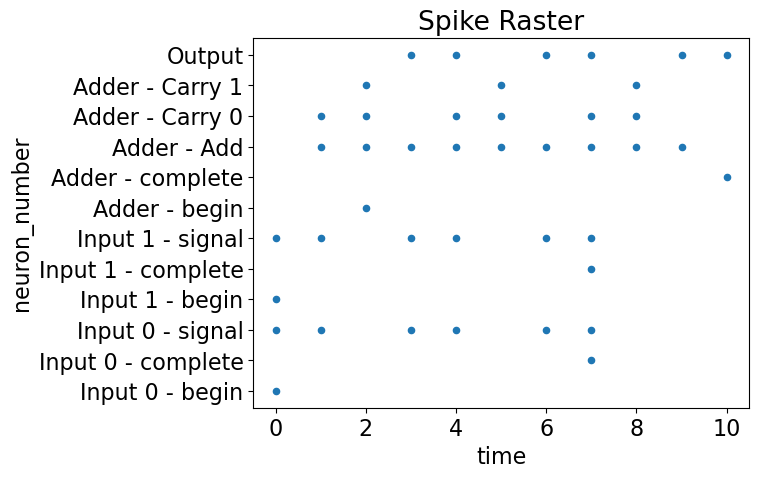

In [7]:
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plt.yticks(np.arange(12), ['Input 0 - begin', 'Input 0 - complete', 'Input 0 - signal', 'Input 1 - begin', 'Input 1 - complete', 'Input 1 - signal', 'Adder - begin', 'Adder - complete', 'Adder - Add', 'Adder - Carry 0', 'Adder - Carry 1', 'Output'])
plt.show()

# Simulation in STACS

In [8]:
backend = stacs_Backend()
backend_args = {}
backend_args['record'] = 'all'
# backend_args['debug_mode'] = False (default), True
backend_args['stacsbin'] = stacs_bin
backend_args['netwkdir'] = './fugunet'
backend_args['filebase'] = 'fugunet'
# backend_args['format'] = 'dataframe' (default), 'eventlist'
backend_args['npdat'] = 2
backend_args['npnet'] = 2
backend_args['nprun'] = 2

backend.compile(scaffold, backend_args)
result_stacs = backend.run(30)

In [9]:
## Note: the default output of STACS is an event list that is sorted implicitly
##       by neuron index and provides ordered timestamps. In the fugu backend,
##       this is be converted to a time-sorted pandas dataframe by default
##
## Note: due to the way inputs are handled through a passthrough layer in STACS,
##       there is a couple of timesteps of delay for when the outputs begin

In [10]:
print(result_stacs)

    time  neuron_number
0    2.0            0.0
1    2.0            2.0
2    2.0            3.0
3    2.0            5.0
4    3.0            2.0
5    3.0            5.0
17   3.0            9.0
16   3.0            8.0
21   4.0           10.0
19   4.0            8.0
18   4.0            6.0
20   4.0            9.0
6    5.0            2.0
23   5.0           11.0
22   5.0            8.0
7    5.0            5.0
25   6.0            9.0
24   6.0            8.0
26   6.0           11.0
9    6.0            5.0
8    6.0            2.0
29   7.0           10.0
27   7.0            8.0
28   7.0            9.0
31   8.0           11.0
10   8.0            2.0
11   8.0            5.0
30   8.0            8.0
32   9.0            8.0
33   9.0            9.0
34   9.0           11.0
12   9.0            1.0
15   9.0            5.0
14   9.0            4.0
13   9.0            2.0
35  10.0            8.0
36  10.0            9.0
37  10.0           10.0
38  11.0            8.0
39  11.0           11.0
40  12.0        

## Plotting output

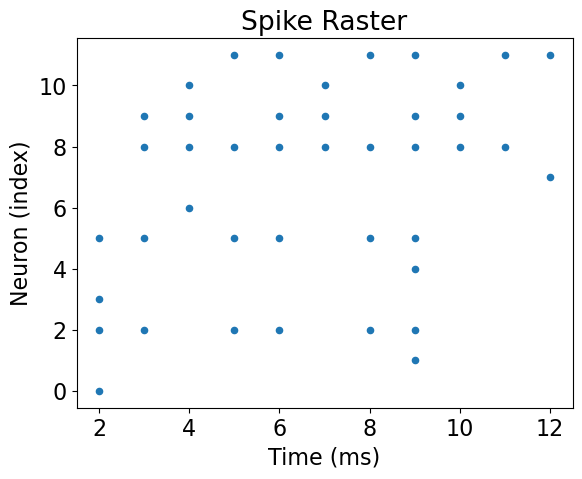

In [11]:
# Plot the event data
result_stacs.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.show()

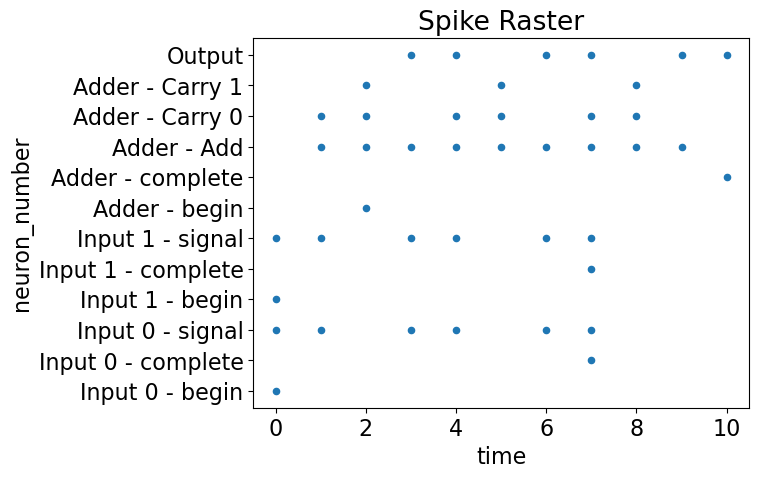

In [12]:
# Just to compare against the Fugu/SNN backend simulated circuit
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plt.yticks(np.arange(12), ['Input 0 - begin', 'Input 0 - complete', 'Input 0 - signal', 'Input 1 - begin', 'Input 1 - complete', 'Input 1 - signal', 'Adder - begin', 'Adder - complete', 'Adder - Add', 'Adder - Carry 0', 'Adder - Carry 1', 'Output'])
plt.show()